# Forecast from two different initial conditions 

Let's fix the two initial condition  for its simplicity. <br>
1. 2025/07/01
2. 2025/07/02

In this notebook, two forecast generated from two initial conditions above will be investigated. <br>
The propagation of the difference between them (anomalie) is expected to be observable by GLONET forecast model.


## Prerequisite

In [192]:
import sys, os

src_path = os.path.abspath(os.path.join(os.getcwd(), "../glonet_daily_forecast_data_orchestration/src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from get_inits import generate_initial_data
from glonet_forecast import create_forecast
from model import synchronize_model_locally
from s3_upload import save_bytes_to_s3

### Fixed input and variables

In [ ]:
EDITO_BUCKET_NAME="project-da-ml"
INPUT_URL_1="https://minio.dive.edito.eu/project-glonet/public/glonet_1_4_daily_forecast/2025-07-01/GLONET_MOI_2025-07-02_2025-07-11.nc"
INPUT_URL_2="https://minio.dive.edito.eu/project-glonet/public/glonet_1_4_daily_forecast/2025-07-02/GLONET_MOI_2025-07-03_2025-07-12.nc"

In [ ]:
import torch

print("PyTorch version:      ", torch.__version__)
print("CUDA available:       ", torch.cuda.is_available())
print("CUDA version (build): ", torch.version.cuda)
print("cuDNN version:        ", torch.backends.cudnn.version())


***
## Forecast

Two initial NetCDF are given to the algorithm.

In [ ]:
cif1, cif2, cif3 = generate_initial_data(bucket_name=EDITO_BUCKET_NAME, 
                                        forecast_netcdf_file_url=INPUT_URL_1)
cif4, cif5, cif6 = generate_initial_data(bucket_name=EDITO_BUCKET_NAME, 
                                        forecast_netcdf_file_url=INPUT_URL_2)

Before forecasting confirm that your model is well synchronized

In [ ]:
local_dir = "../TrainedWeights"
synchronize_model_locally(local_dir=local_dir)

Make two different forecast from two different input.

In [ ]:
forecast_1 = create_forecast(forecast_netcdf_file_url=INPUT_URL_1,
                                model_dir=local_dir, 
                                initial_file_1_url=cif1, 
                                initial_file_2_url=cif2, 
                                initial_file_3_url=cif3)

forecast_2 = create_forecast(forecast_netcdf_file_url=INPUT_URL_2,
                                model_dir=local_dir, 
                                initial_file_1_url=cif4, 
                                initial_file_2_url=cif5, 
                                initial_file_3_url=cif6)

***
***
# Visualization
There are too many cases to plot every windows.. let's simplify the code. <br>
Let's define what we are going to investigate :
1. State
2. Depth of the state
3. Forecast day

What is the state which you interest in ?
(Simply choose one state and uncomment it for investigate) <br>
If the states in interest are Temperature, Salinity and Currnet, the depth must be given. **0 ~ 20** (surface to -5000m) <br>
Which forecast file should be plotted ? **0 ~ 9** (GLONET makes 10-day repetitive forecast one day by one day)

In [257]:
state = 'zos'
# state = 'thetao'
# state = 'so'
# state = 'uo'
# state = 'vo'

# If the state is 'thetao' or 'so' or 'uo or 'vo', Choose depth between 0 ~ 20.
depth_index = 0

# What forecast cycle that you are interested in ? For 7 days cycle, the time index is 6. 
time_index = 6


For better visualization, different color map is chosen for each state.

In [258]:
match state :
    case "zos" :
        cmap_param = "seismic"
    case "thetao" :
        cmap_param = "viridis"
    case "so" :
        cmap_param = "jet"
    case "uo" :
        cmap_param = "coolwarm"
    case "vo" :
        cmap_param = "coolwarm"

### Overview of the two forecast output

(array(-1.96418691), array(1.37680101))

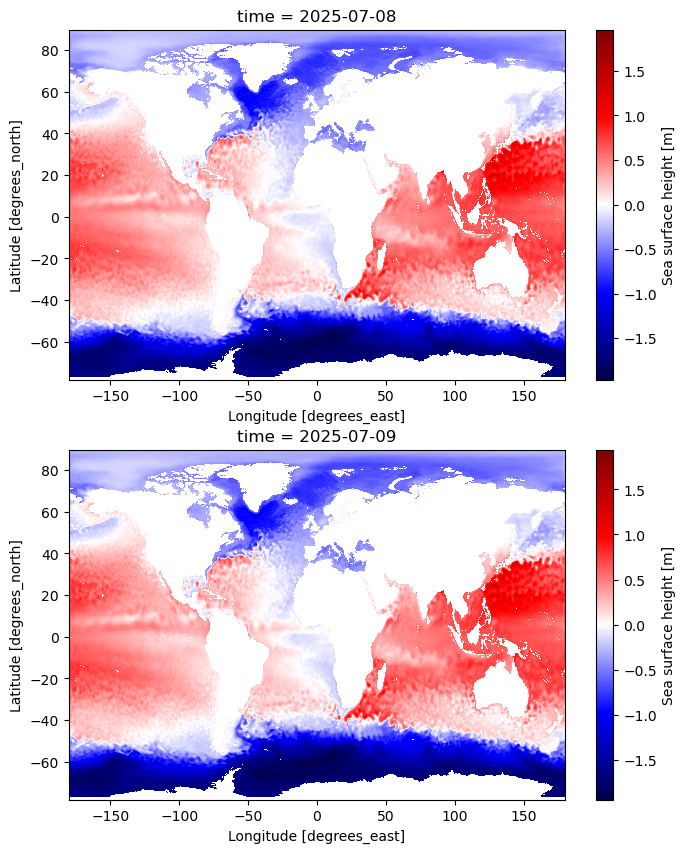

In [259]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 10))

plt.subplot(2, 1, 1)
# (missing_dims = 'ignore') parameter allow us to simplify the code by igonoring depth coordinate at 'zos' variable.
state_window1 = forecast_1[state].isel(depth=depth_index, time=time_index, missing_dims='ignore') 
state_window1.plot(cmap=cmap_param)

plt.subplot(2, 1, 2)
state_window2 = forecast_2[state].isel(depth=depth_index, time=time_index, missing_dims='ignore')
state_window2.plot(cmap=cmap_param)

# Define plot variable range 
xmin = state_window1.min().values
xmax = state_window1.max().values

xmin, xmax


***
### Investigate more precisely
- Zone#1 : South Africa Agulhas Current
- Zone#2 : East America Gulf Stream
- Zone#3 : East Asia Kuroshio Current

Plot info <br>
 - First column : Forecast from input 1 $(A_1)$
 - Second column : Forecast from input 2 $(B_1)$

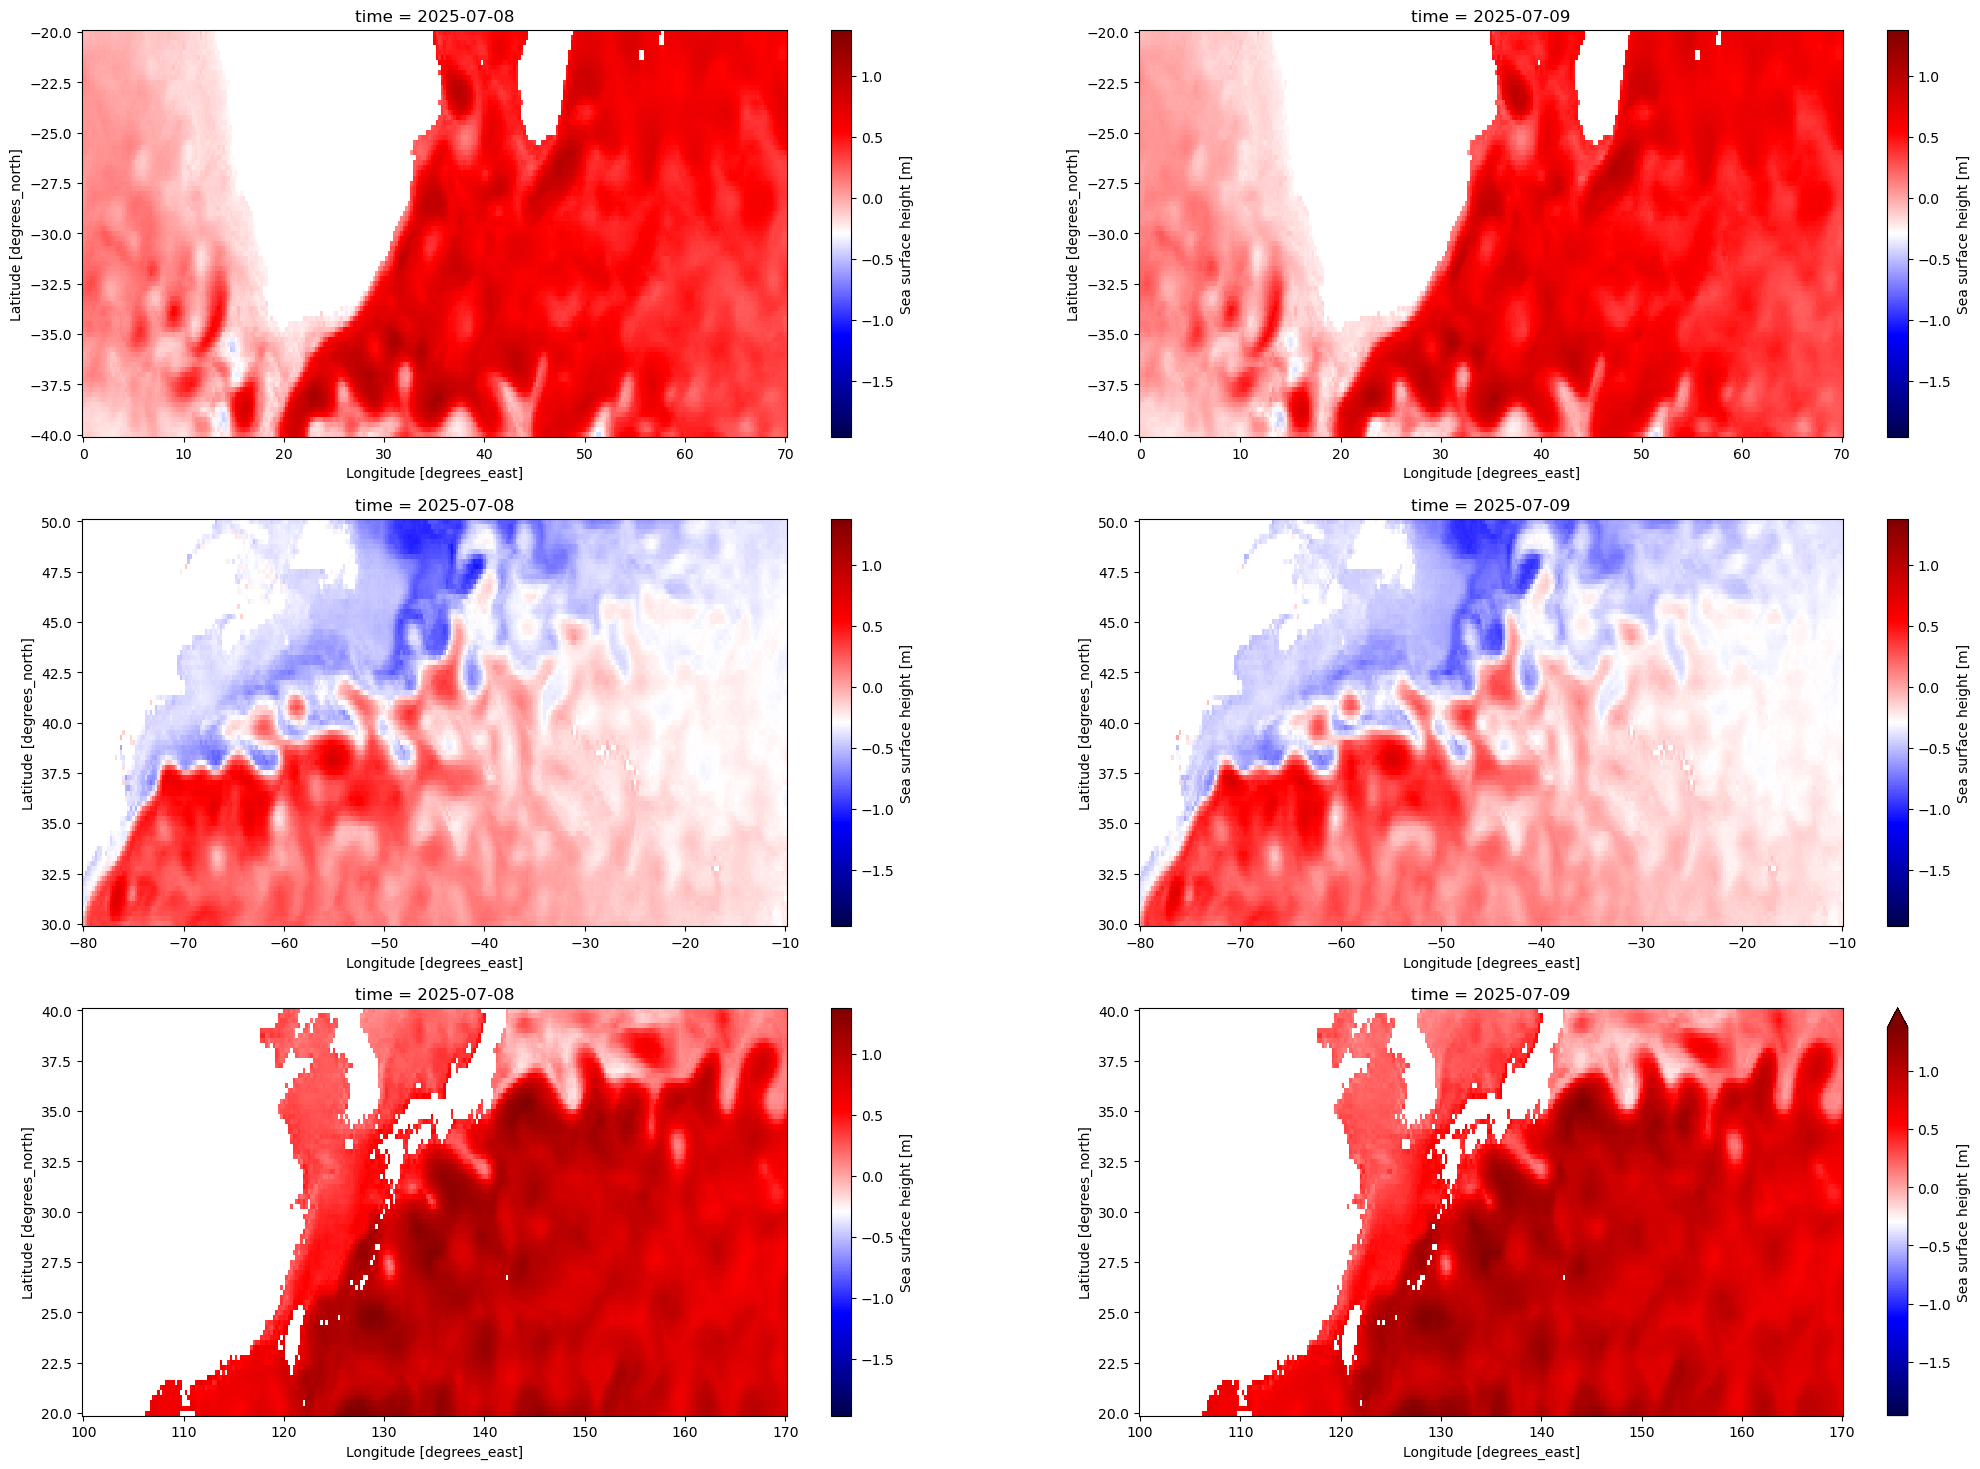

In [260]:
# Define the zoom region (latitude and longitude bounds)
lat_min1, lat_max1, lat_min2, lat_max2, lat_min3, lat_max3 = -40, -20, 30 , 50, 20, 40
lon_min1, lon_max1, lon_min2, lon_max2, lon_min3, lon_max3 = 0, 70, -80, -10, 100, 170

zone1_forecast1 = state_window1.sel(latitude=slice(lat_min1, lat_max1), longitude=slice(lon_min1, lon_max1))
zone2_forecast1 = state_window1.sel(latitude=slice(lat_min2, lat_max2), longitude=slice(lon_min2, lon_max2))
zone3_forecast1 = state_window1.sel(latitude=slice(lat_min3, lat_max3), longitude=slice(lon_min3, lon_max3))

zone1_forecast2 = state_window2.sel(latitude=slice(lat_min1, lat_max1), longitude=slice(lon_min1, lon_max1))
zone2_forecast2 = state_window2.sel(latitude=slice(lat_min2, lat_max2), longitude=slice(lon_min2, lon_max2))
zone3_forecast2 = state_window2.sel(latitude=slice(lat_min3, lat_max3), longitude=slice(lon_min3, lon_max3))

# Define the size of subplot
plt.figure(figsize=(25, 18))

# Plot
plt.subplot(3, 2 ,1)
zone1_forecast1.plot(cmap=cmap_param, vmin=xmin, vmax=xmax)
plt.subplot(3, 2, 2)
zone1_forecast2.plot(cmap=cmap_param, vmin=xmin, vmax=xmax)

plt.subplot(3, 2 ,3)
zone2_forecast1.plot(cmap=cmap_param, vmin=xmin, vmax=xmax)
plt.subplot(3, 2, 4)
zone2_forecast2.plot(cmap=cmap_param, vmin=xmin, vmax=xmax)

plt.subplot(3, 2 ,5)
zone3_forecast1.plot(cmap=cmap_param, vmin=xmin, vmax=xmax)
plt.subplot(3, 2, 6)
zone3_forecast2.plot(cmap=cmap_param, vmin=xmin, vmax=xmax)

***
In order to see the difference more clearly, let's plot `forecast1 - forecast2` and compare with the difference of input.

Plot info <br>
 - First column : Difference between input1 and input2 $(A_0 - B_0)$
 - Second column : Difference between forecast1 and forecast2 $(A_1 - B_1)$

This illustrate how the difference (anomalie) propagate along with the GLONET along forecast. 

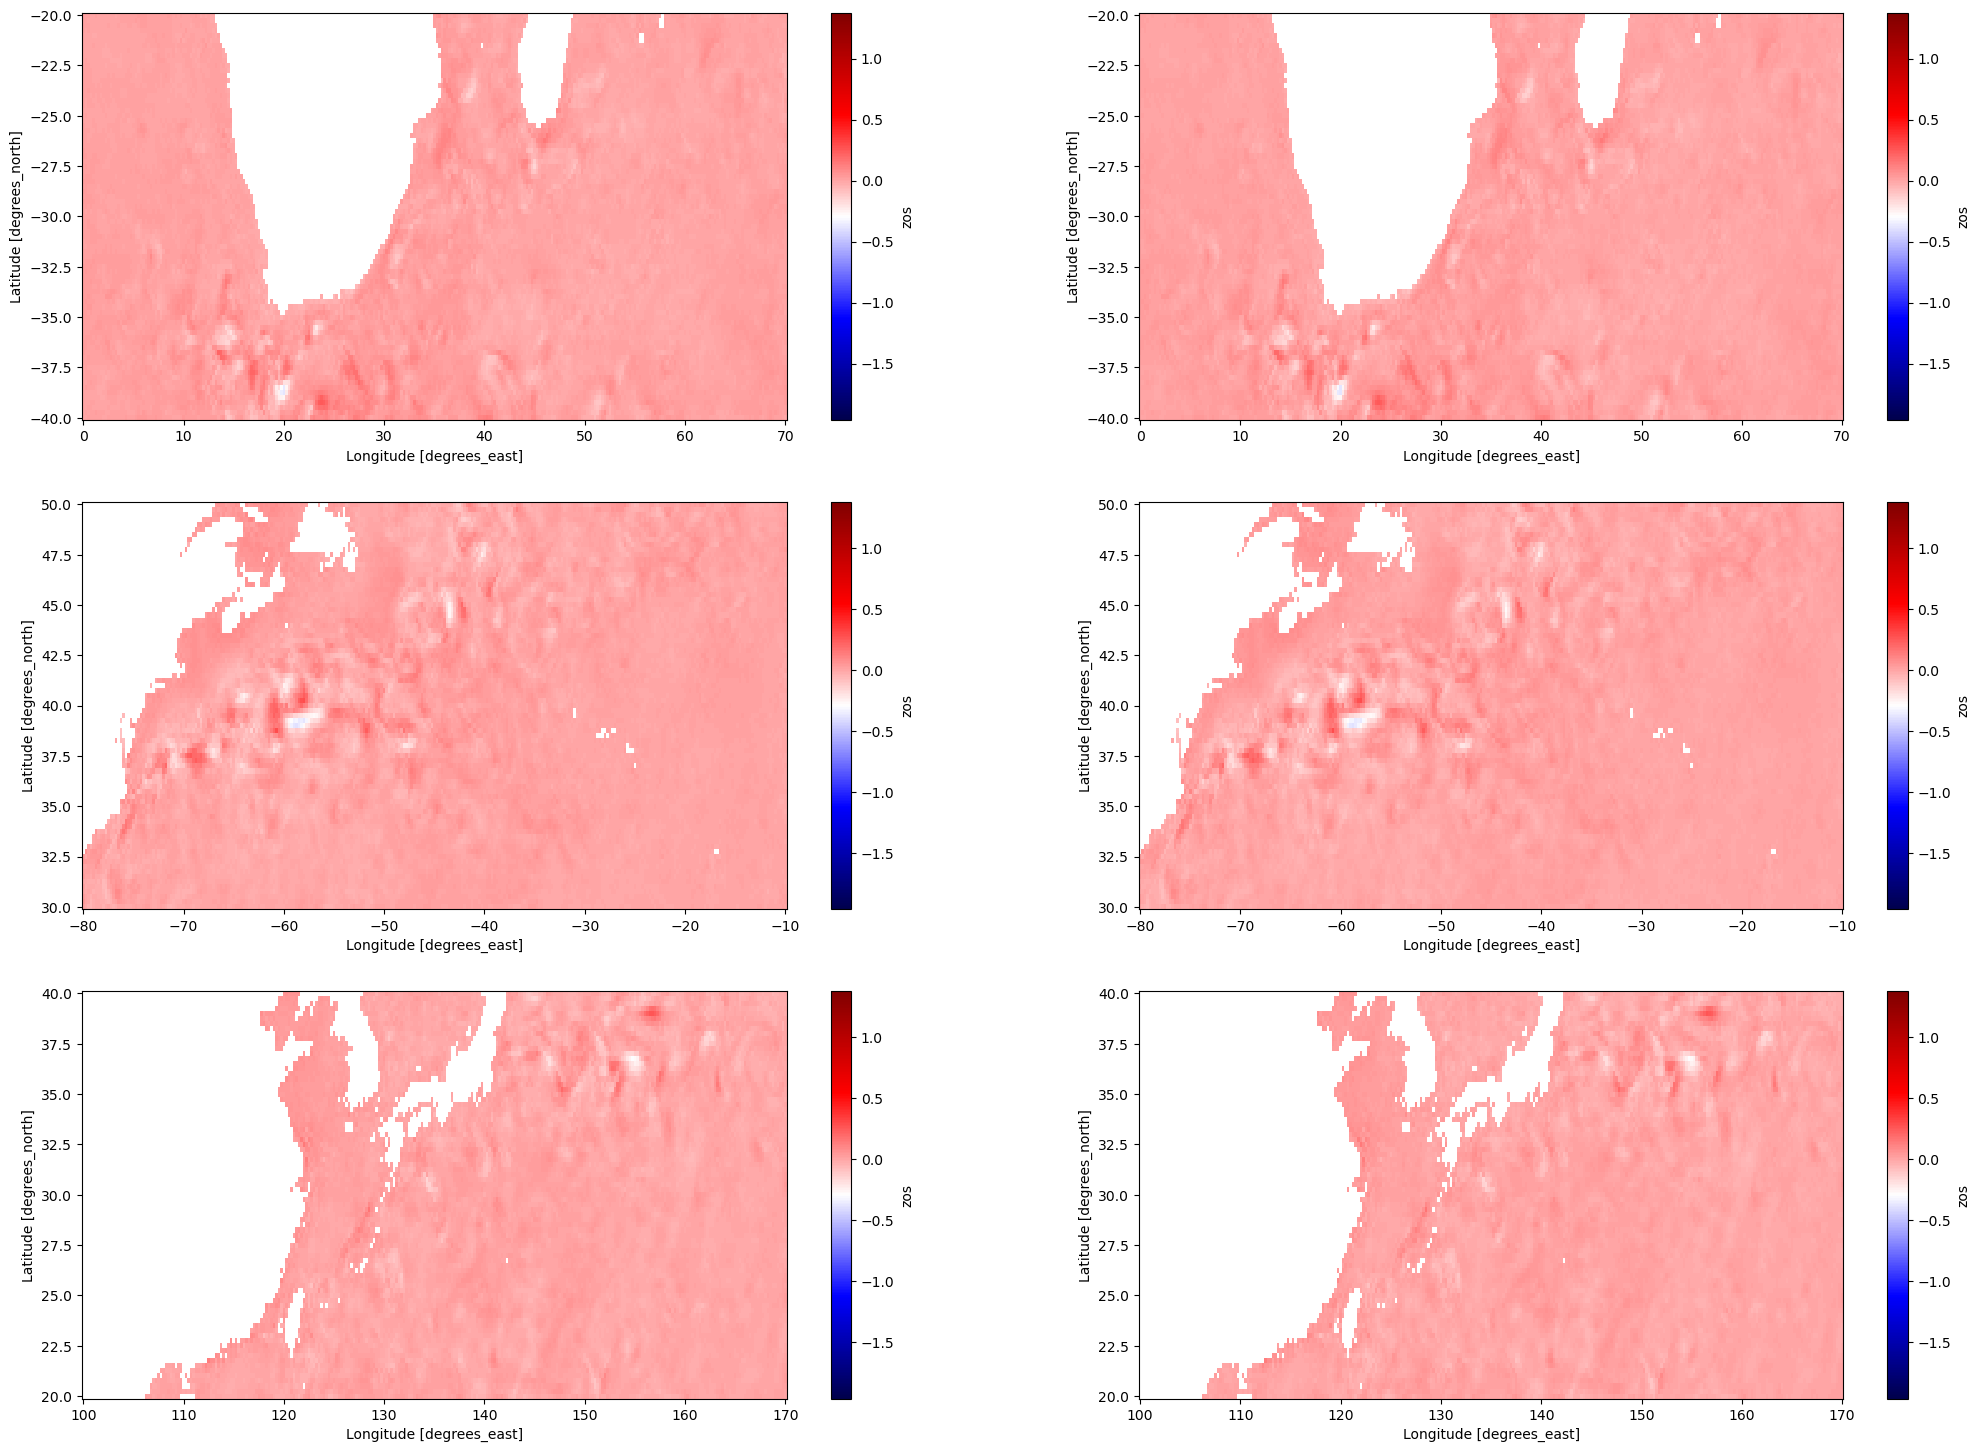

In [261]:
import xarray as xr

# Get entire input netCDF file
input_nc1 = xr.open_dataset(f"{INPUT_URL_1}#mode=bytes", engine="netcdf4")[state].isel(depth=depth_index, time=time_index, missing_dims='ignore')
input_nc2 = xr.open_dataset(f"{INPUT_URL_2}#mode=bytes", engine="netcdf4")[state].isel(depth=depth_index, time=time_index, missing_dims='ignore')

#Calculate diff
forecast_diff = state_window1 - state_window2
input_diff = input_nc1 - input_nc2

# Define zone
zone1_input_diff = input_diff.sel(latitude=slice(lat_min1, lat_max1), longitude=slice(lon_min1, lon_max1))
zone2_input_diff = input_diff.sel(latitude=slice(lat_min2, lat_max2), longitude=slice(lon_min2, lon_max2))
zone3_input_diff = input_diff.sel(latitude=slice(lat_min3, lat_max3), longitude=slice(lon_min3, lon_max3))

zone1_forecast_diff = forecast_diff.sel(latitude=slice(lat_min1, lat_max1), longitude=slice(lon_min1, lon_max1))
zone2_forecast_diff = forecast_diff.sel(latitude=slice(lat_min2, lat_max2), longitude=slice(lon_min2, lon_max2))
zone3_forecast_diff = forecast_diff.sel(latitude=slice(lat_min3, lat_max3), longitude=slice(lon_min3, lon_max3))

# Define the size of subplot
plt.figure(figsize=(25, 18))

# Plot
plt.subplot(3, 2 ,1)
zone1_input_diff.plot(cmap=cmap_param, vmin=xmin, vmax=xmax)
plt.subplot(3, 2, 2)
zone1_forecast_diff.plot(cmap=cmap_param, vmin=xmin, vmax=xmax)

plt.subplot(3, 2 ,3)
zone2_input_diff.plot(cmap=cmap_param, vmin=xmin, vmax=xmax)
plt.subplot(3, 2, 4)
zone2_forecast_diff.plot(cmap=cmap_param, vmin=xmin, vmax=xmax)

plt.subplot(3, 2 ,5)
zone3_input_diff.plot(cmap=cmap_param, vmin=xmin, vmax=xmax)
plt.subplot(3, 2, 6)
zone3_forecast_diff.plot(cmap=cmap_param, vmin=xmin, vmax=xmax)

***
For one day forecast, it seems that the deviation of the input is almost same in the deviation of the output. <br>
It is also hard to verify the difference with this plots. <br>
Then, let's do `diff_forecast(right column) - diff_input(left column)` $((A_1 - B_1) - (A_0 - B_0))$ <br>

Plot info <br>

both side are the **same plots** but in different scaling.
 - Left : Same scale as the global forecasting
 - Right : Scale that fits to the diffdiff $((A_1 - B_1) - (A_0 - B_0))$

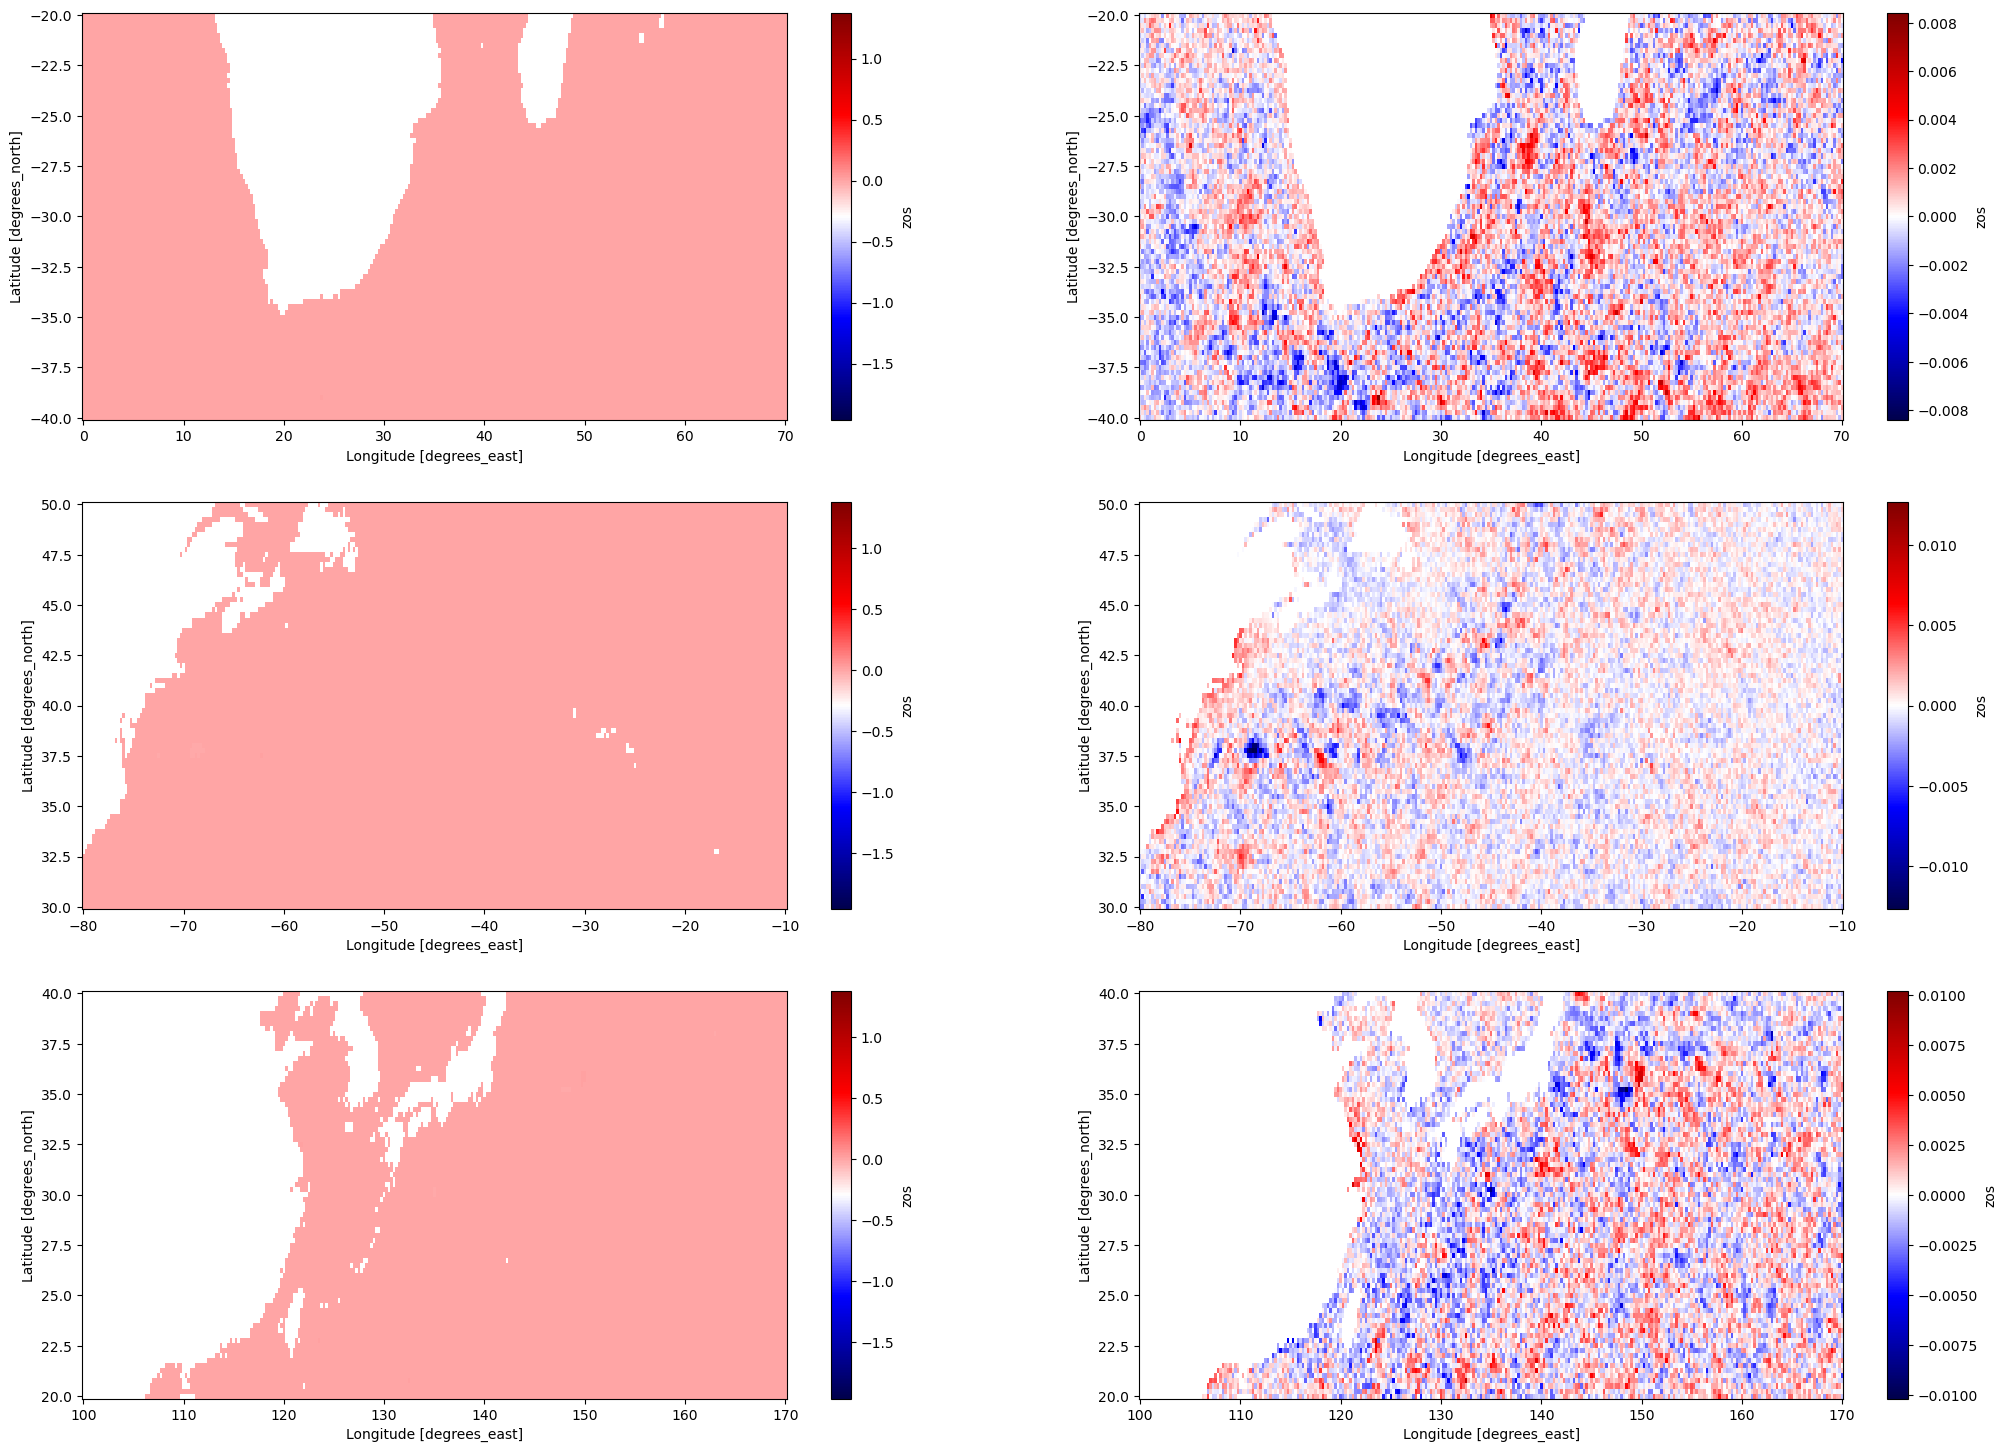

In [262]:
plt.figure(figsize=(25, 18))

plt.subplot(3, 2, 1)
(zone1_forecast_diff - (zone1_input_diff)).plot(cmap=cmap_param, vmin=xmin, vmax=xmax)
plt.subplot(3, 2, 2)
(zone1_forecast_diff - (zone1_input_diff)).plot(cmap=cmap_param)

plt.subplot(3, 2, 3)
(zone2_forecast_diff - (zone2_input_diff)).plot(cmap=cmap_param, vmin=xmin, vmax=xmax)
plt.subplot(3, 2, 4)
(zone2_forecast_diff - (zone2_input_diff)).plot(cmap=cmap_param)

plt.subplot(3, 2, 5)
(zone3_forecast_diff - (zone3_input_diff)).plot(cmap=cmap_param, vmin=xmin, vmax=xmax)
plt.subplot(3, 2, 6)
(zone3_forecast_diff - (zone3_input_diff)).plot(cmap=cmap_param)



***
For one-day forecast & for Absolute Dynamic Topology, it is hard to say something. <br>

!! Attention !!

Initialize `diff_forecast_arr` only first interation at `time index = 0`

In [263]:
import pandas as pd
from datetime import datetime, timedelta

# Save the previous result

# Extract date for url (string)
forecast_date = INPUT_URL_1.split("/")[6]

# Make result Dataset by adding time coordinate.
diff_arr = forecast_diff.expand_dims(time=[pd.Timestamp(datetime.strptime(forecast_date, "%Y-%m-%d") + timedelta(days=time_index+1))])
diffdiff_arr = (forecast_diff - input_diff).expand_dims(time=[pd.Timestamp(datetime.strptime(forecast_date, "%Y-%m-%d") + timedelta(days=time_index+1))])

# Initialize Dataarray (Dataset)
# Attention !
# Only first time, then comment follow line
# diff_forecast_arr = input_diff.expand_dims(time=[pd.Timestamp(datetime.strptime(forecast_date, "%Y-%m-%d"))]) # <- uncomment this line
# diffdiff_forecast_arr = (input_diff-input_diff).expand_dims(time=[pd.Timestamp(datetime.strptime(forecast_date, "%Y-%m-%d"))]) # <- uncomment this line

In [264]:
diff_forecast_arr = xr.concat([diff_forecast_arr, diff_arr], dim="time")
diffdiff_forecast_arr = xr.concat([diffdiff_forecast_arr, diffdiff_arr], dim="time")

Check the cumulated result in array. <br>
***Don't forget the uncomment `diff_forecast_arr` for the iteration !!***

In [265]:
# diff_forecast_arr
# diffdiff_forecast_arr

***!!!*** <br>
***Go back to Visulaization chapter to accumulate the forecast***

In [ ]:
print("Did you make enough forecast?")

***
***
## Visualize the all the diffdiff and look at their diff ^^
First things first 

In [266]:

# We cannot define the zone every time. 

from xarray import Dataset

def defineZone(inputnc) -> Dataset :
    lat_min1, lat_max1, lat_min2, lat_max2, lat_min3, lat_max3 = -40, -20, 30 , 50, 20, 40
    lon_min1, lon_max1, lon_min2, lon_max2, lon_min3, lon_max3 = 0, 70, -80, -10, 100, 170
    arr = []
    arr.append(inputnc.sel(latitude=slice(lat_min1, lat_max1), longitude=slice(lon_min1, lon_max1))) # Agulhas
    arr.append(inputnc.sel(latitude=slice(lat_min2, lat_max2), longitude=slice(lon_min2, lon_max2))) # Gulf Stream
    arr.append(inputnc.sel(latitude=slice(lat_min3, lat_max3), longitude=slice(lon_min3, lon_max3))) # Kuroshio

    return arr


### For-loop 
static figure. 
1. diff

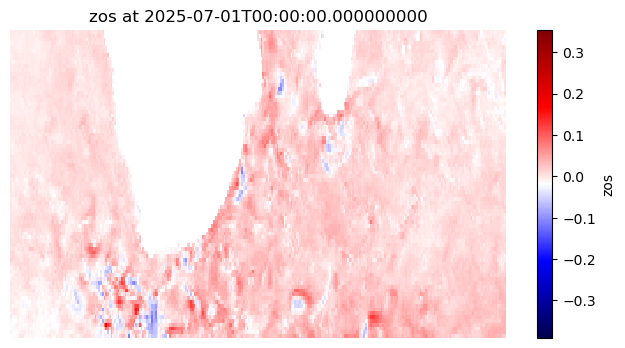

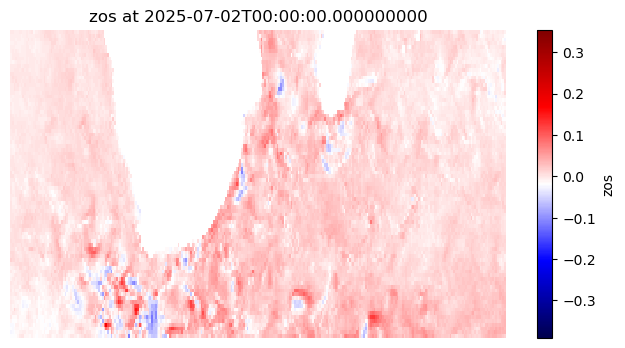

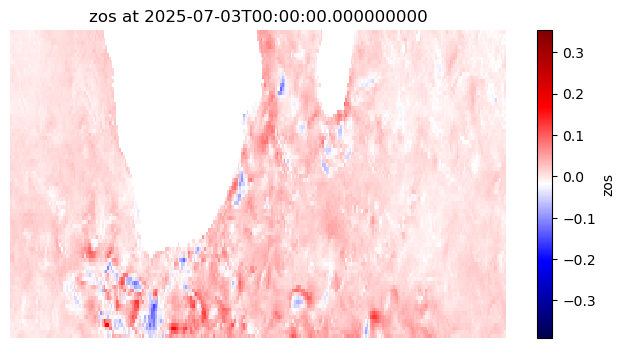

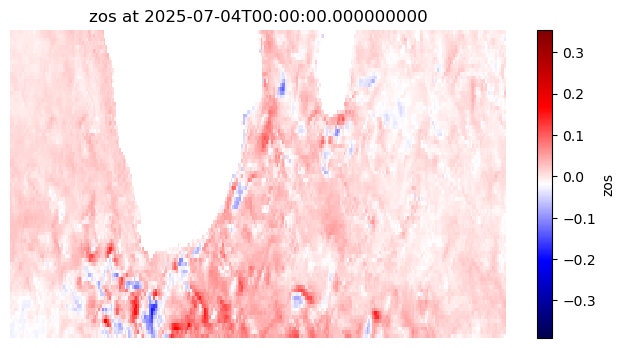

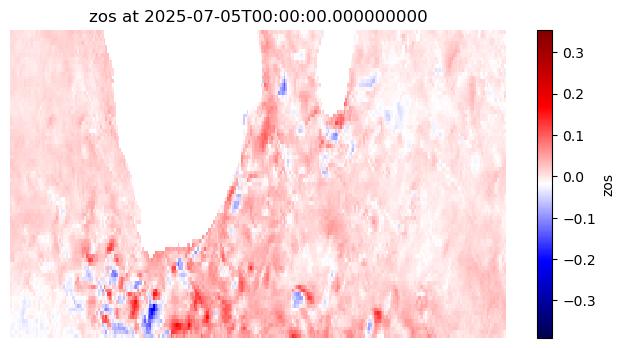

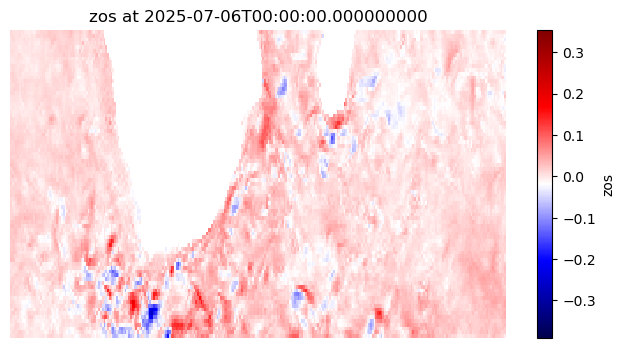

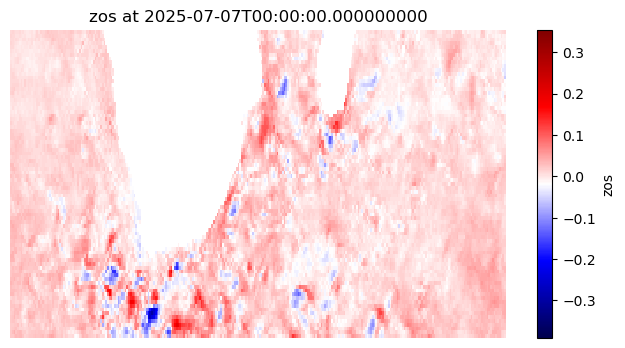

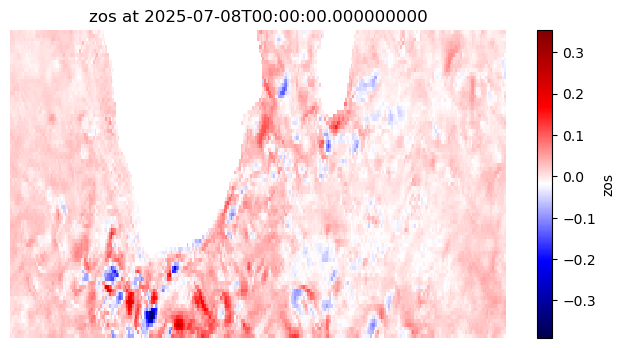

In [268]:
#Extract time variable
time = diff_forecast_arr['time']

#Fix scaling
xdiffmin = diff_forecast_arr.isel(time=len(time)-1).min().values # Last forecast for fix to biggest scale
xdiffmax = diff_forecast_arr.isel(time=len(time)-1).max().values 



for i in range(len(time)):
    plt.figure(figsize=(8, 4))
    ############################# Interactive #############################
    defineZone(diff_forecast_arr)[0].isel(time=i).plot(cmap=cmap_param, vmin = xdiffmin, vmax = xdiffmax) # <-- select 0 for Agulhas, 1 for Gulf Stream and 2 for Kuroshio.
    plt.title(f"{diff_forecast_arr.name} at {str(time[i].values)}")
    plt.axis("off")           # optional
    plt.show()


2. diffidfff

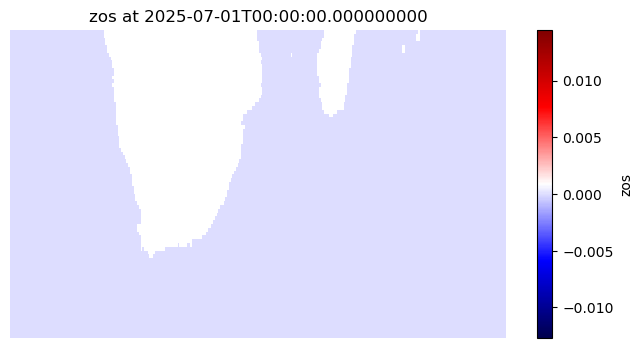

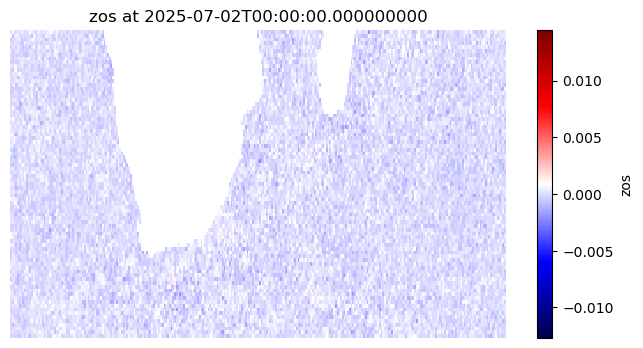

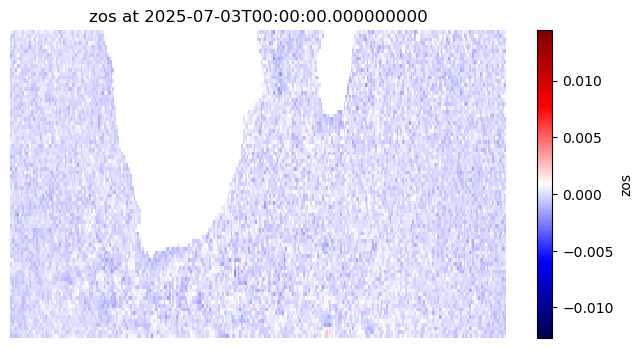

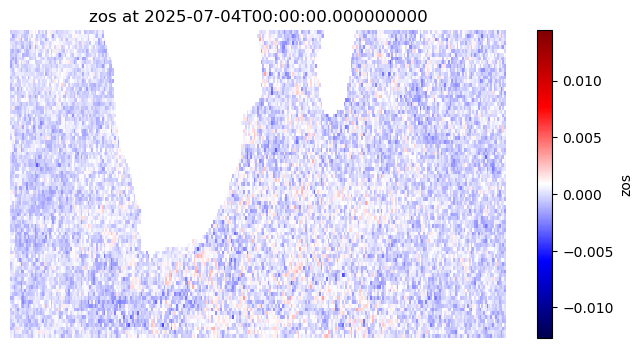

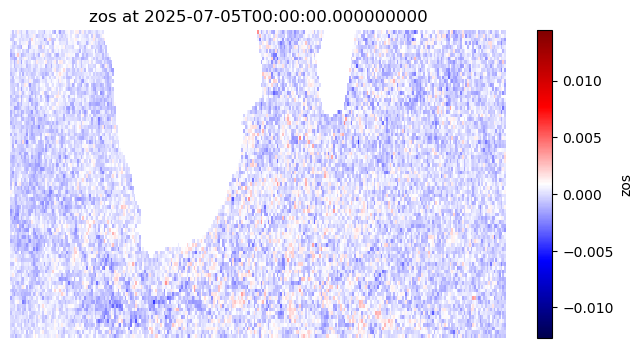

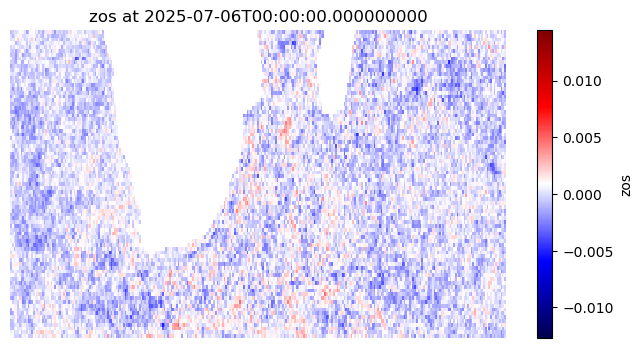

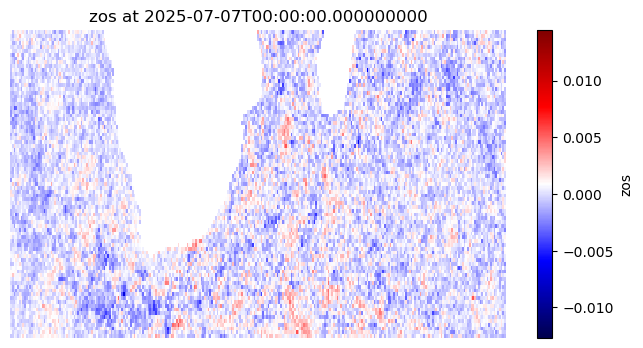

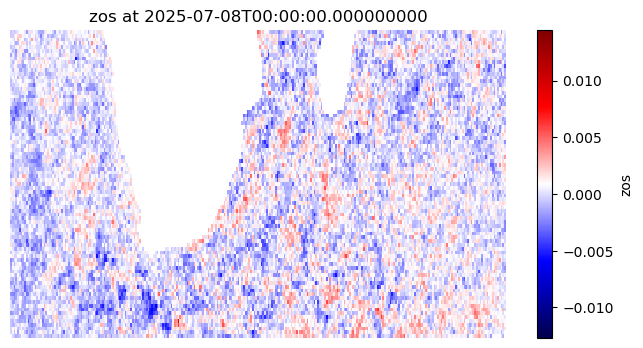

In [269]:
time = diffdiff_forecast_arr['time']

#Fix scaling
xdiffdiffmin = diffdiff_forecast_arr.isel(time=len(time)-1).min().values # Last forecast for fix to biggest scale
xdiffdiffmax = diffdiff_forecast_arr.isel(time=len(time)-1).max().values 

for i in range(len(time)):
    plt.figure(figsize=(8, 4))
    ############################# Interactive #############################
    defineZone(diffdiff_forecast_arr)[0].isel(time=i).plot(cmap=cmap_param, vmin=xdiffdiffmin, vmax=xdiffdiffmax) # <-- select 0 for Agulhas, 1 for Gulf Stream and 2 for Kuroshio.
    plt.title(f"{diffdiff_forecast_arr.name} at {str(time[i].values)}")
    plt.axis("off")           # optional
    plt.show()

### Interact mode
Dynamic figure
1. diff

In [ ]:
%pip install ipywidgets

from matplotlib import animation
from ipywidgets import interact, IntSlider

time = diff_forecast_arr['time']

def view_time(idx):
    for i in range (0,3) :
        plt.figure(figsize=(4, 2))
        defineZone(diff_forecast_arr)[i].isel(time=idx).plot(cmap=cmap_param, vmin=xdiffmin, vmax=xdiffmax)
        plt.title(f"{diff_forecast_arr.name} at {str(time[idx].values)}")
        plt.axis("off")
        plt.show()

slider = IntSlider(min=0, max=len(diff_forecast_arr['time'])-1, step=1, value=0)
interact(view_time, idx=slider)


Note: you may need to restart the kernel to use updated packages.


interactive(children=(IntSlider(value=0, description='idx', max=7), Output()), _dom_classes=('widget-interact'…

<function __main__.view_time(idx)>

2. diffdiff

In [ ]:
time = diffdiff_forecast_arr['time']

def view_time(idx):
    for i in range (0,3) :
        plt.figure(figsize=(4, 2))
        
        defineZone(diffdiff_forecast_arr)[i].isel(time=idx).plot(cmap=cmap_param, vmin=xdiffdiffmin, vmax=xdiffdiffmax)
        plt.title(f"{diffdiff_forecast_arr.name} at {str(time[idx].values)}")
        plt.axis("off")
        plt.show()

slider = IntSlider(min=0, max=len(diffdiff_forecast_arr['time'])-1, step=1, value=0)
interact(view_time, idx=slider)


interactive(children=(IntSlider(value=0, description='idx', max=7), Output()), _dom_classes=('widget-interact'…

<function __main__.view_time(idx)>